In [ ]:
teams = {
        "Atlanta Hawks": 1610612737,
        "Boston Celtics": 1610612738,
        "Brooklyn Nets": 1610612751,
        "Charlotte Bobcats": 1610612766,
        "Charlotte Hornets": 1610612766,
        "Chicago Bulls": 1610612741,
        "Cleveland Cavaliers": 1610612739,
        "Dallas Mavericks": 1610612742,
        "Denver Nuggets": 1610612743,
        "Detroit Pistons": 1610612765,
        "Golden State Warriors": 1610612744,
        "Houston Rockets": 1610612745,
        "Indiana Pacers": 1610612754,
        "LA Clippers": 1610612746,
        "Los Angeles Clippers": 1610612746,
        "Los Angeles Lakers": 1610612747,
        "Memphis Grizzlies": 1610612763,
        "Miami Heat": 1610612748,
        "Milwaukee Bucks": 1610612749,
        "Minnesota Timberwolves": 1610612750,
        "New Jersey Nets": 1610612751,
        "New Orleans Hornets": 1610612740,
        "New Orleans Pelicans": 1610612740,
        "New York Knicks": 1610612752,
        "Oklahoma City Thunder": 1610612760,
        "Orlando Magic": 1610612753,
        "Philadelphia 76ers": 1610612755,
        "Phoenix Suns": 1610612756,
        "Portland Trail Blazers": 1610612757,
        "Sacramento Kings": 1610612758,
        "San Antonio Spurs": 1610612759,
        "Toronto Raptors": 1610612761,
        "Utah Jazz": 1610612762,
        "Washington Wizards": 1610612764,
    }

available_stats = {'W_PCT': 'Base',
                   'FG_PCT': 'Base',
                   'FG3_PCT': 'Base',
                   'FT_PCT': 'Base',
                   'REB': 'Base',
                   'AST': 'Base',
                   'TOV': 'Base',
                   'STL': 'Base',
                   'BLK': 'Base',
                   'PLUS_MINUS': 'Base',
                   'OFF_RATING': 'Advanced',
                   'DEF_RATING': 'Advanced',
                   'TS_PCT': 'Advanced'}


In [ ]:
#from team_names import teams\
import nba_api
from nba_api.stats.endpoints import teamdashboardbygeneralsplits, leaguedashteamstats
import time
import pandas as pd


def get_team_stats_dict(team, start_date, end_date, season='2021-22'):
    """
    Returns the stats for the specified team in a dataframe, default year is 2020-21
    :param team: Day of games scheduled in form 'mm/dd/yyyy'
    :param season: Day of games scheduled in form 'mm/dd/yyyy'
    :return: A dictionary of game matchups {home_team:[away_team]}
    """

    time.sleep(1)

    general_team_info = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id=teams[team],
                                                                                  per_mode_detailed='Per100Possessions',
                                                                                  season=season,
                                                                                  date_from_nullable=start_date,
                                                                                  date_to_nullable=end_date,

                                                                                  timeout=120)
    general_team_dict = general_team_info.get_normalized_dict()
    general_team_dashboard = general_team_dict['OverallTeamDashboard'][0]

    win_percentage = general_team_dashboard['W_PCT']
    fg_percentage = general_team_dashboard['FG_PCT']
    fg3_percentage = general_team_dashboard['FG3_PCT']
    ft_percentage = general_team_dashboard['FT_PCT']
    rebounds = general_team_dashboard['REB']
    assists = general_team_dashboard['AST']
    turnovers = general_team_dashboard['TOV']
    steals = general_team_dashboard['STL']
    blocks = general_team_dashboard['BLK']
    plus_minus = general_team_dashboard['PLUS_MINUS']

    advanced_team_info = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id=teams[team],
                                                                                   measure_type_detailed_defense='Advanced',
                                                                                   season=season,
                                                                                   date_from_nullable=start_date,
                                                                                   date_to_nullable=end_date,
                                                                                   
                                                                                   timeout=120)
    advanced_team_dict = advanced_team_info.get_normalized_dict()
    advanced_team_dashboard = advanced_team_dict['OverallTeamDashboard'][0]

    offensive_rating = advanced_team_dashboard['OFF_RATING']
    defensive_rating = advanced_team_dashboard['DEF_RATING']
    true_shooting_percentage = advanced_team_dashboard['TS_PCT']

    all_stats_dict = {
        'W_PCT': win_percentage,
        'FG_PCT': fg_percentage,
        'FG3_PCT': fg3_percentage,
        'FT_PCT': ft_percentage,
        'REB': rebounds,
        'AST': assists,
        'TOV': turnovers,
        'STL': steals,
        'BLK': blocks,
        'PLUS_MINUS': plus_minus,
        'OFF_RATING': offensive_rating,
        'DEF_RATING': defensive_rating,
        'TS_PCT': true_shooting_percentage
    }

    return all_stats_dict

get_team_stats_dict('Golden State Warriors', '10/19/2021', '04/10/2022', '2021-22')

In [ ]:

from nba_api.stats.endpoints import leaguegamelog, scoreboard
#from team_names import teams


def get_match_results(date, season):
    """
    Returns the matchup and result of the game

    :param date: Day of games scheduled in form 'mm/dd/yyyy'
    :param season: Season in form of 'yyyy-yy'
    :return: [{Boston Celtics: Los Angeles Lakers}], ['W']
    """
    game_log = leaguegamelog.LeagueGameLog(season=season, league_id='00', date_from_nullable=date,
                                           date_to_nullable=date, season_type_all_star='Regular Season', timeout=120)
    game_log_dict = game_log.get_normalized_dict()
    list_of_teams = game_log_dict['LeagueGameLog']

    daily_match = {}
    win_loss = []

    for i in range(0, len(list_of_teams), 2):

        if '@' in list_of_teams[i]['MATCHUP']:

            away_team = list_of_teams[i]['TEAM_NAME']
            home_team = list_of_teams[i + 1]['TEAM_NAME']

            win_loss.append(list_of_teams[i + 1]['WL'])

        else:
            away_team = list_of_teams[i + 1]['TEAM_NAME']
            home_team = list_of_teams[i]['TEAM_NAME']
            win_loss.append(list_of_teams[i]['WL'])

        daily_match.update({away_team: home_team})

    match_results = [daily_match, win_loss]

    return match_results


def get_daily_matches(date):
    """
    This method creates a dictionary of daily game matchups.

    :param date: Day of games scheduled in form 'mm/dd/yyyy'
    :return: A dictionary of game matchups {home_team:away_team}
    """

    daily_match = scoreboard.Scoreboard(league_id='00', game_date=date, timeout=120)
    daily_match_dict = daily_match.get_normalized_dict()
    games = daily_match_dict['GameHeader']

    match = {}

    for game in games:

        home_team_id = game['HOME_TEAM_ID']

        for team, team_id in teams.items():
            if team_id == home_team_id:
                home_team = team

        away_team_id = game['VISITOR_TEAM_ID']

        for team, team_id in teams.items():
            if team_id == away_team_id:
                away_team = team

        match.update({away_team: home_team})

    return match


def main():
    print(f"""'get_daily_matches' returns a dictionary of the games on a specified date\n{get_daily_matches('05/01/22')}\n""")
    print(f"""'get_match_results' returns the matchup plus the result\n{get_match_results('10/19/2021', '2021-22')}""")



In [ ]:
from datetime import date, timedelta
import pandas as pd
import requests

#from get_stats import get_team_stats_dict
#from get_matches import get_match_results
#from standardization import z_score, stat_std, stat_mean
#from available_stats import available_stats


# [{'Sacramento Kings': 'Boston Celtics', 'Charlotte Hornets': 'Philadelphia 76ers'}, ['W', 'L']]
# team stats is a dataframe
def to_dataframe(daily_games, start_date, end_date, season): #, mean_dict, std_dict):
    full_dataframe = []
    game_number = 0  # counter to match with the correct game
    daily_results = daily_games[1]  # win or loss for each game

    for home_team, away_team in daily_games[0].items():  # loops through matchups
        home_team_stats = get_team_stats_dict(home_team, start_date, end_date, season)
        away_team_stats = get_team_stats_dict(away_team, start_date, end_date, season)

        current_game = [away_team, home_team]

        for stat, stat_type in available_stats.items():
            current_game.append(home_team_stats[stat])

        for stat, stat_type in available_stats.items():
            current_game.append(away_team_stats[stat])


        #for stat, stat_type in available_stats.items():
        #    z_score_diff = z_score_difference(home_team_stats[stat], away_team_stats[stat], mean_dict[stat], std_dict[stat])

         #   current_game.append(z_score_diff)

        if daily_results[game_number] == 'W':
            result = 1
        else:
            result = 0

        current_game.append(result)
        game_number += 1

        print(current_game)

        full_dataframe.append(current_game)

    return full_dataframe

# daily_games = get_match_results('10/19/2021', '2021-22')
# daily_games
# to_dataframe(daily_games, start_date='10/19/2021', end_date='04/10/2022', season='2021-22')

def date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
        

def training_set(start_year, start_month, start_day, end_year, end_month, end_day, season, season_start):
    start_date = date(start_year, start_month, start_day)
    end_date = date(end_year, end_month, end_day)

    total_games = []

    for single_date in date_range(start_date, end_date):
        current_date = single_date.strftime('%m/%d/%Y')
        print(current_date)

        previous_day = single_date - timedelta(days=1)
        previous_day_formatted = previous_day.strftime('%m/%d/%Y')

        #mean_std_dictionary = mean_std_dict(season_start, previous_day_formatted, season)
        #mean_dict = mean_std_dictionary[0]
        #std_dict = mean_std_dictionary[1]

        current_day_games = get_match_results(current_date, season)
        current_day_games_with_stats = to_dataframe(current_day_games, season_start, previous_day_formatted, season)

        for game in current_day_games_with_stats:
            game.append(current_date)
            total_games.append(game)

    print(total_games)
    return total_games


def make_dataframe(game_list):
    games = pd.DataFrame(game_list,
                         columns=['Home', 'Away', 'H_W_PCT', 'H_FG_PCT', 'H_FG3_PCT', 'H_FT_PCT', 'H_REB', 'H_AST', 'H_TOV', 'H_STL',
                                  'H_BLK', 'H_PLUS_MINUS', 'H_OFF_RATING', 'H_DEF_RATING', 'H_TS_PCT', 'A_W_PCT', 'A_FG_PCT', 'A_FG3_PCT',
                                  'A_FT_PCT', 'A_REB', 'A_AST', 'A_TOV', 'A_STL',
                                  'A_BLK', 'A_PLUS_MINUS', 'A_OFF_RATING', 'A_DEF_RATING', 'A_TS_PCT','Result', 'Date'])

    print(games)
    return games


def main():
    attempts = 10

    for i in range(attempts):
        try:
            all_games = training_set(start_year=2021, start_month=12, start_day=25, end_year=2023, end_month=1, end_day=1,
                             season='2021-22', season_start='10/19/2021')
            df = make_dataframe(all_games)

            print(df)
            df.to_csv(r'C:\Users\alvaro\OneDrive\Documents\School\Flatiron\Projects\NBA_Model\nba_22_data.csv', index=False)
        except requests.exceptions.ReadTimeout:
            if i < attempts - 1:
                continue
            else:
                raise
        break
main()

#if __name__ == '__main__':
    #main()



# Dataset

## 2018-2019

In [ ]:
import pandas as pd
df_2018 = pd.read_csv('./nba_data/nba_df_2018.csv')
df_2018['Date'] = pd.to_datetime(df_2018['Date'])
df_2018['Season'] = '2018-19'
len(df_2018)

## 2019 - 2020

In [ ]:
df_2019 = pd.read_csv('./nba_data/nba_df_2019.csv')
df_2019['Date'] = pd.to_datetime(df_2019['Date'])
df_2019['Season'] = '2019-20'

df_2019_2 = pd.read_csv('./nba_data/nba_df_2019_2.csv')
df_2019_2['Date'] = pd.to_datetime(df_2019_2['Date'])
df_2019_2['Season'] = '2019-20'

print(len(df_2019), len(df_2019_2))

In [ ]:
frames = [df_2019, df_2019_2]
df_2019_final = pd.concat(frames)
len(df_2019_final)

## 2020 - 2021

In [ ]:
df_2020 = pd.read_csv('./nba_data/nba_df_2020.csv')
df_2020['Date'] = pd.to_datetime(df_2020['Date'])
df_2020['Season'] = '2020-21'
len(df_2020)

In [ ]:
frames = [df_2018, df_2019_final, df_2020]
df = pd.concat(frames)
df = df.reset_index(drop=True)

In [ ]:
df = df.reset_index(drop=True)
len(df)

# Last N Games Win %

In [ ]:
import warnings
warnings.filterwarnings("ignore")
prev_game_df = df[df['Date'] < '12/12/2020'][(df['Home'] == "Milwaukee Bucks") | (df['Away'] == 'Milwaukee Bucks')].sort_values(by = 'Date').tail(10)
prev_game_df
h_df = prev_game_df.iloc[:, range(0,32,31)]

h_df = h_df.loc[h_df['Home'] == 'Milwaukee Bucks'] 
print(h_df)

In [ ]:
def get_avg_win_pct_last_n_games(team, game_date, df, n):
    prev_game_df = df[df['Date'] < game_date][(df['Home'] == team) | (df['Away'] == team)].sort_values(by = 'Date').tail(n)
    
    wins = 0 
    
    result_df = prev_game_df.iloc[:, range(0,32,31)]
    h_df = result_df.loc[result_df['Home'] == team] 
    
    h_wins = h_df.loc[h_df['Result'] == 1]
    
    wins += len(h_wins)
      
    a_df = result_df.loc[result_df['Home'] != team]
    a_wins = a_df.loc[a_df['Result'] == 0]
    
    wins += len(a_wins)

    return wins/n
get_avg_win_pct_last_n_games('Milwaukee Bucks', '12/12/2020', df, 10)

In [ ]:
for season in df['Season'].unique() :
    
    season_stats = df[df['Season'] == season].sort_values(by='Date').reset_index(drop=True)
    
    for index, row in df.iterrows() : 
        game_id = row['Game_ID']
        game_date = row['Date']
        h_team = row['Home']
        a_team = row['Away']
        
        df.loc[index,'Home_W_Pct_10'] = get_avg_win_pct_last_n_games(h_team, game_date, df, 10)
        
        df.loc[index,'Away_W_Pct_10'] = get_avg_win_pct_last_n_games(a_team, game_date, df, 10)
        

In [ ]:
df[df['Season'] == '2020-21'].tail()


In [ ]:
df

# ELO Rating
- every team starts with a 1500
$$R_{i+1} = k * (S_{team} - E_{team} + R_{i})$$
- S team is 1 if the team wins and 0 if they lose
- E team is the expected win probability of the team 
$$E_{team} = \frac{1}{1+10^{\frac{opp\_elo - team\_elo}{400}}}$$
- k is a moving constant that depends on margin of victory and difference in Elo ratings
$$k = 20\frac{(MOV_{winner} + 3)^{0.8}}{7.5 + 0.006(elo\_difference_{winner})} $$
- team year by year carryover 
$$(R * 0.75) + (0.25 * 1505)$$

In [ ]:
df.head()

In [ ]:
# Home and road team win probabilities implied by Elo ratings and home court adjustment 
import math
import time
def win_probs(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a*h
    home_prob = a*h / denom
    away_prob = r / denom 
  
    return home_prob, away_prob

  #odds the home team will win based on elo ratings and home court advantage

def home_odds_on(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400)
    return a*h/r

#this function determines the constant used in the elo rating, based on margin of victory and difference in elo ratings
def elo_k(MOV, elo_diff):
    k = 20 # Optimal K is 20 https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier


# Updates the home and away teams elo ratings after a game 

def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)
    
    return updated_home_elo, updated_away_elo


# Takes into account prev season elo
# The reason we revert to a mean of 1505 rather than 1500 is that 
# there are liable to be a couple of relatively recent expansion teams in the league at any given time
def get_prev_elo(team, date, season, team_stats, elo_df) :
    prev_game = team_stats[team_stats['Date'] < game_date][(team_stats['Home'] == team) | (team_stats['Away'] == team)].sort_values(by = 'Date').tail(1).iloc[0] 

    if team == prev_game['Home'] :
        elo_rating = elo_df[elo_df['Game_ID'] == prev_game['Game_ID']]['H_Team_Elo_After'].values[0]
    else :
        elo_rating = elo_df[elo_df['Game_ID'] == prev_game['Game_ID']]['A_Team_Elo_After'].values[0]
  
    if prev_game['Season'] != season :
        return (0.75 * elo_rating) + (0.25 * 1505) # Year-to-Year Carry-Over
    else :
        return elo_rating

In [ ]:
df.sort_values(by = 'Date', inplace = True)
df.reset_index(inplace=True, drop = True)
elo_df = pd.DataFrame(columns=['Game_ID', 'H_Team', 'A_Team', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['Game_ID','Team', 'Elo', 'Date', 'Where_Played', 'Season']) 

for index, row in df.iterrows(): 
    game_id = row['Game_ID']
    game_date = row['Date']
    season = row['Season']
    h_team, a_team = row['Home'], row['Away']
    h_score, a_score = row['H_Score'], row['A_Score'] 

    if (h_team not in elo_df['H_Team'].values and h_team not in elo_df['A_Team'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, df, elo_df)

    if (a_team not in elo_df['H_Team'].values and a_team not in elo_df['A_Team'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, df, elo_df)

    h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

    new_row = {'Game_ID': game_id, 'H_Team': h_team, 'A_Team': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
    teams_row_one = {'Game_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'Date': game_date, 'Where_Played': 'Home', 'Season': season}
    teams_row_two = {'Game_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'Date': game_date, 'Where_Played': 'Away', 'Season': season}
  
    elo_df = elo_df.append(new_row, ignore_index = True)
    teams_elo_df = teams_elo_df.append(teams_row_one, ignore_index=True)
    teams_elo_df = teams_elo_df.append(teams_row_two, ignore_index=True)

In [ ]:
#teams_elo_df.set_index(["Team"], append=True)
#dataset = teams_elo_df.pivot(index="Team",values="Elo", columns="Date")
dates = list(set([d.strftime("%m-%d-%Y") for d in teams_elo_df["Date"]]))
dates = sorted(dates, key=lambda x: time.strptime(x, '%m-%d-%Y'))
teams = df["Away"]
dataset = pd.DataFrame(columns=dates)
dataset["Team"] = teams.drop_duplicates()
dataset = dataset.set_index("Team")

for index, row in teams_elo_df.iterrows():
    date = row["Date"].strftime("%m-%d-%Y")
    team = row["Team"]
    elo = row["Elo"]
    dataset[date][team] = elo

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)

elo_df

In [ ]:
df.head()

In [ ]:
df = df.merge(elo_df.drop(columns=['H_Team', 'A_Team']), on ='Game_ID')
df.head()

# Merging Dataset

# Standardization and Z Score

In [ ]:
df.head()

# Evaluate Different Models - No Z Score

In [ ]:
df.to_csv(r'C:\Users\alvaro\OneDrive\Documents\School\Flatiron\Projects\NBA_Model\nba_data\nba_df_final_test.csv', index = False)
print(f'The final dataset consists of three seasons and {len(df)} games.')
df = df.reset_index(drop=True)
df.tail()


In [ ]:
df.head()
df = df.drop(labels=['H_Team_Elo_After', 'A_Team_Elo_After'], axis=1)
df.head()

In [ ]:
df["H_Team_Elo_Before"] = df.H_Team_Elo_Before.astype(float)
df["A_Team_Elo_Before"] = df.A_Team_Elo_Before.astype(float)
final_df = df.drop(['Home', 'Away', 'Game_ID', 'H_Score', 'A_Score', 'Date', 'Season'], axis=1)
#final_df.head()
#final_df.columns
#final_df.info()
final_df.columns

In [ ]:
final_df.to_csv(r'C:\Users\alvaro\OneDrive\Documents\School\Flatiron\Projects\NBA_Model\nba_data\nbas.csv', index = False)

In [1]:
import pandas as pd
final_df = pd.read_csv('./nba_data/nbas.csv')

# EDA

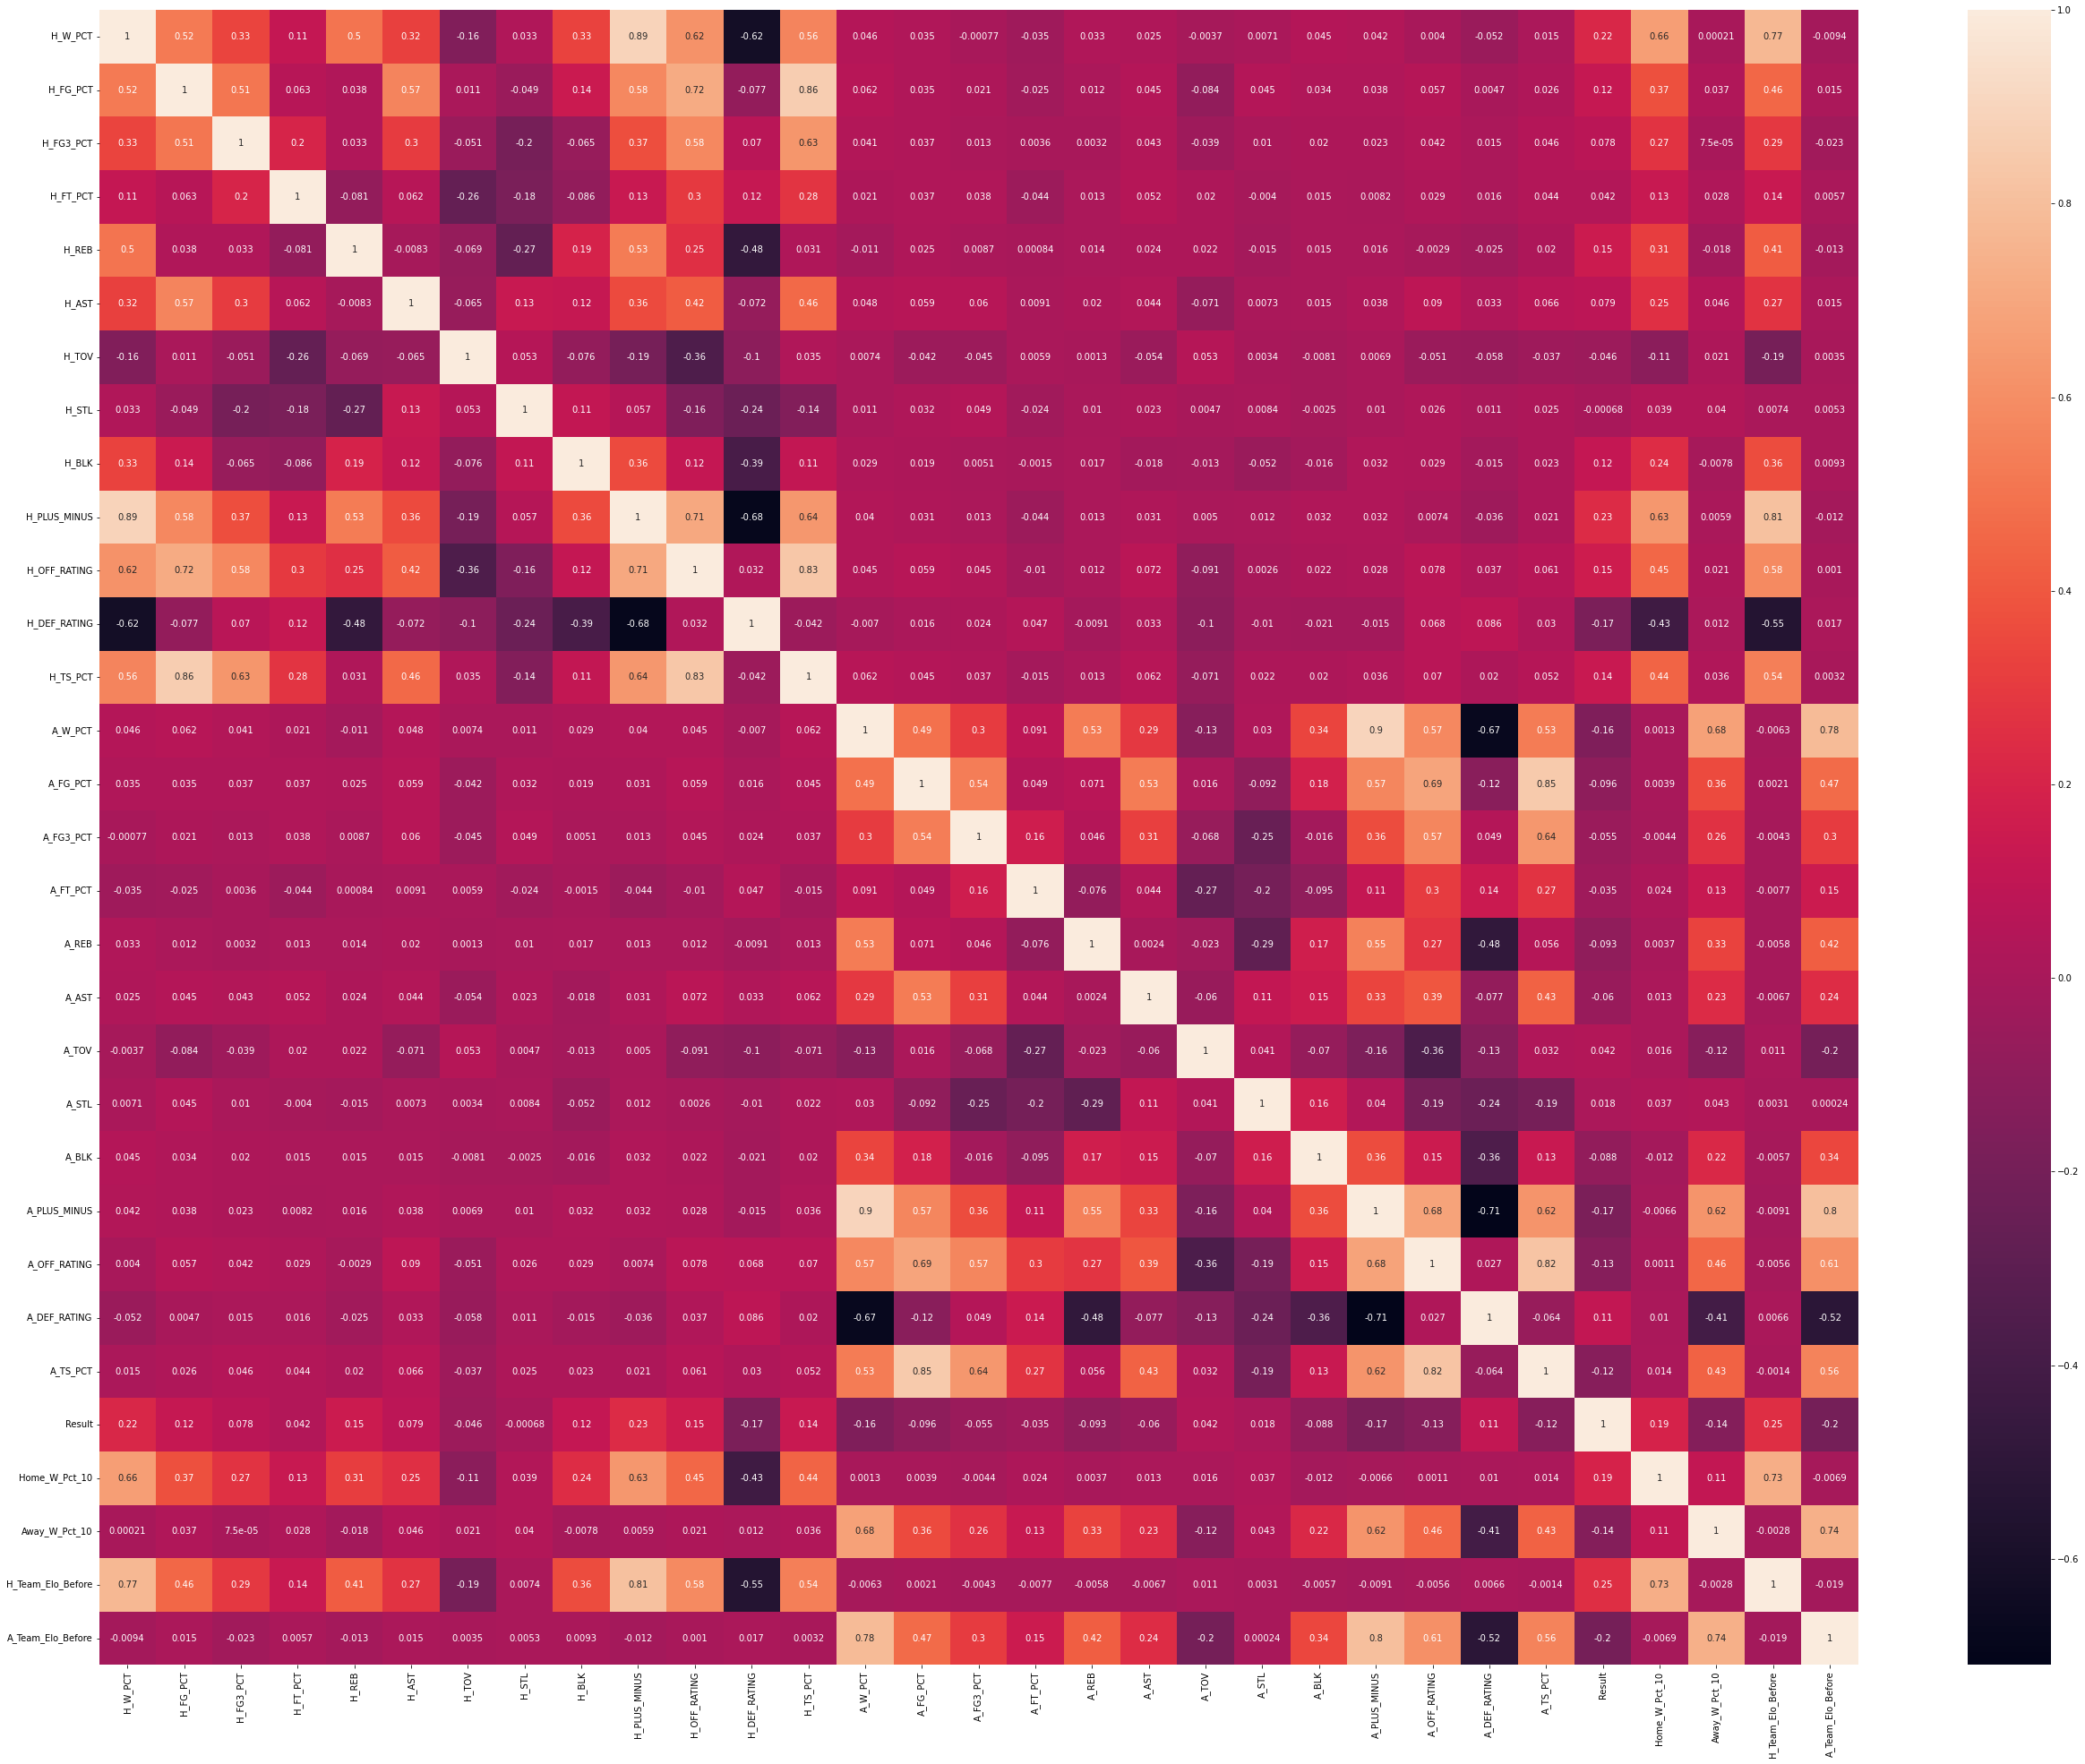

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(44, 34))

sns.heatmap(final_df.corr(), annot=True);

# correlation = final_df[['H_W_PCT', 'H_REB', 'H_AST',
#        'H_TOV', 'H_STL', 'H_BLK', 'H_PLUS_MINUS', 'H_OFF_RATING',
#        'H_DEF_RATING', 'H_TS_PCT', 'H_Team_Elo_Before', 'Home_W_Pct_10', 'Result']].corr()
# sns.heatmap(final_df['Result'].corr(), annot=True)

In [3]:
final_df.corr()['Result'].abs().sort_values(ascending=False)

Result               1.000000
H_Team_Elo_Before    0.250024
H_PLUS_MINUS         0.232983
H_W_PCT              0.216308
A_Team_Elo_Before    0.197502
Home_W_Pct_10        0.194694
H_DEF_RATING         0.171022
A_PLUS_MINUS         0.170770
A_W_PCT              0.156699
H_OFF_RATING         0.152380
H_REB                0.146231
Away_W_Pct_10        0.141192
H_TS_PCT             0.137470
A_OFF_RATING         0.128770
A_TS_PCT             0.124219
H_FG_PCT             0.119288
H_BLK                0.117469
A_DEF_RATING         0.110086
A_FG_PCT             0.095614
A_REB                0.092672
A_BLK                0.088289
H_AST                0.078898
H_FG3_PCT            0.078364
A_AST                0.060419
A_FG3_PCT            0.054604
H_TOV                0.045599
H_FT_PCT             0.042027
A_TOV                0.041703
A_FT_PCT             0.034755
A_STL                0.017767
H_STL                0.000680
Name: Result, dtype: float64

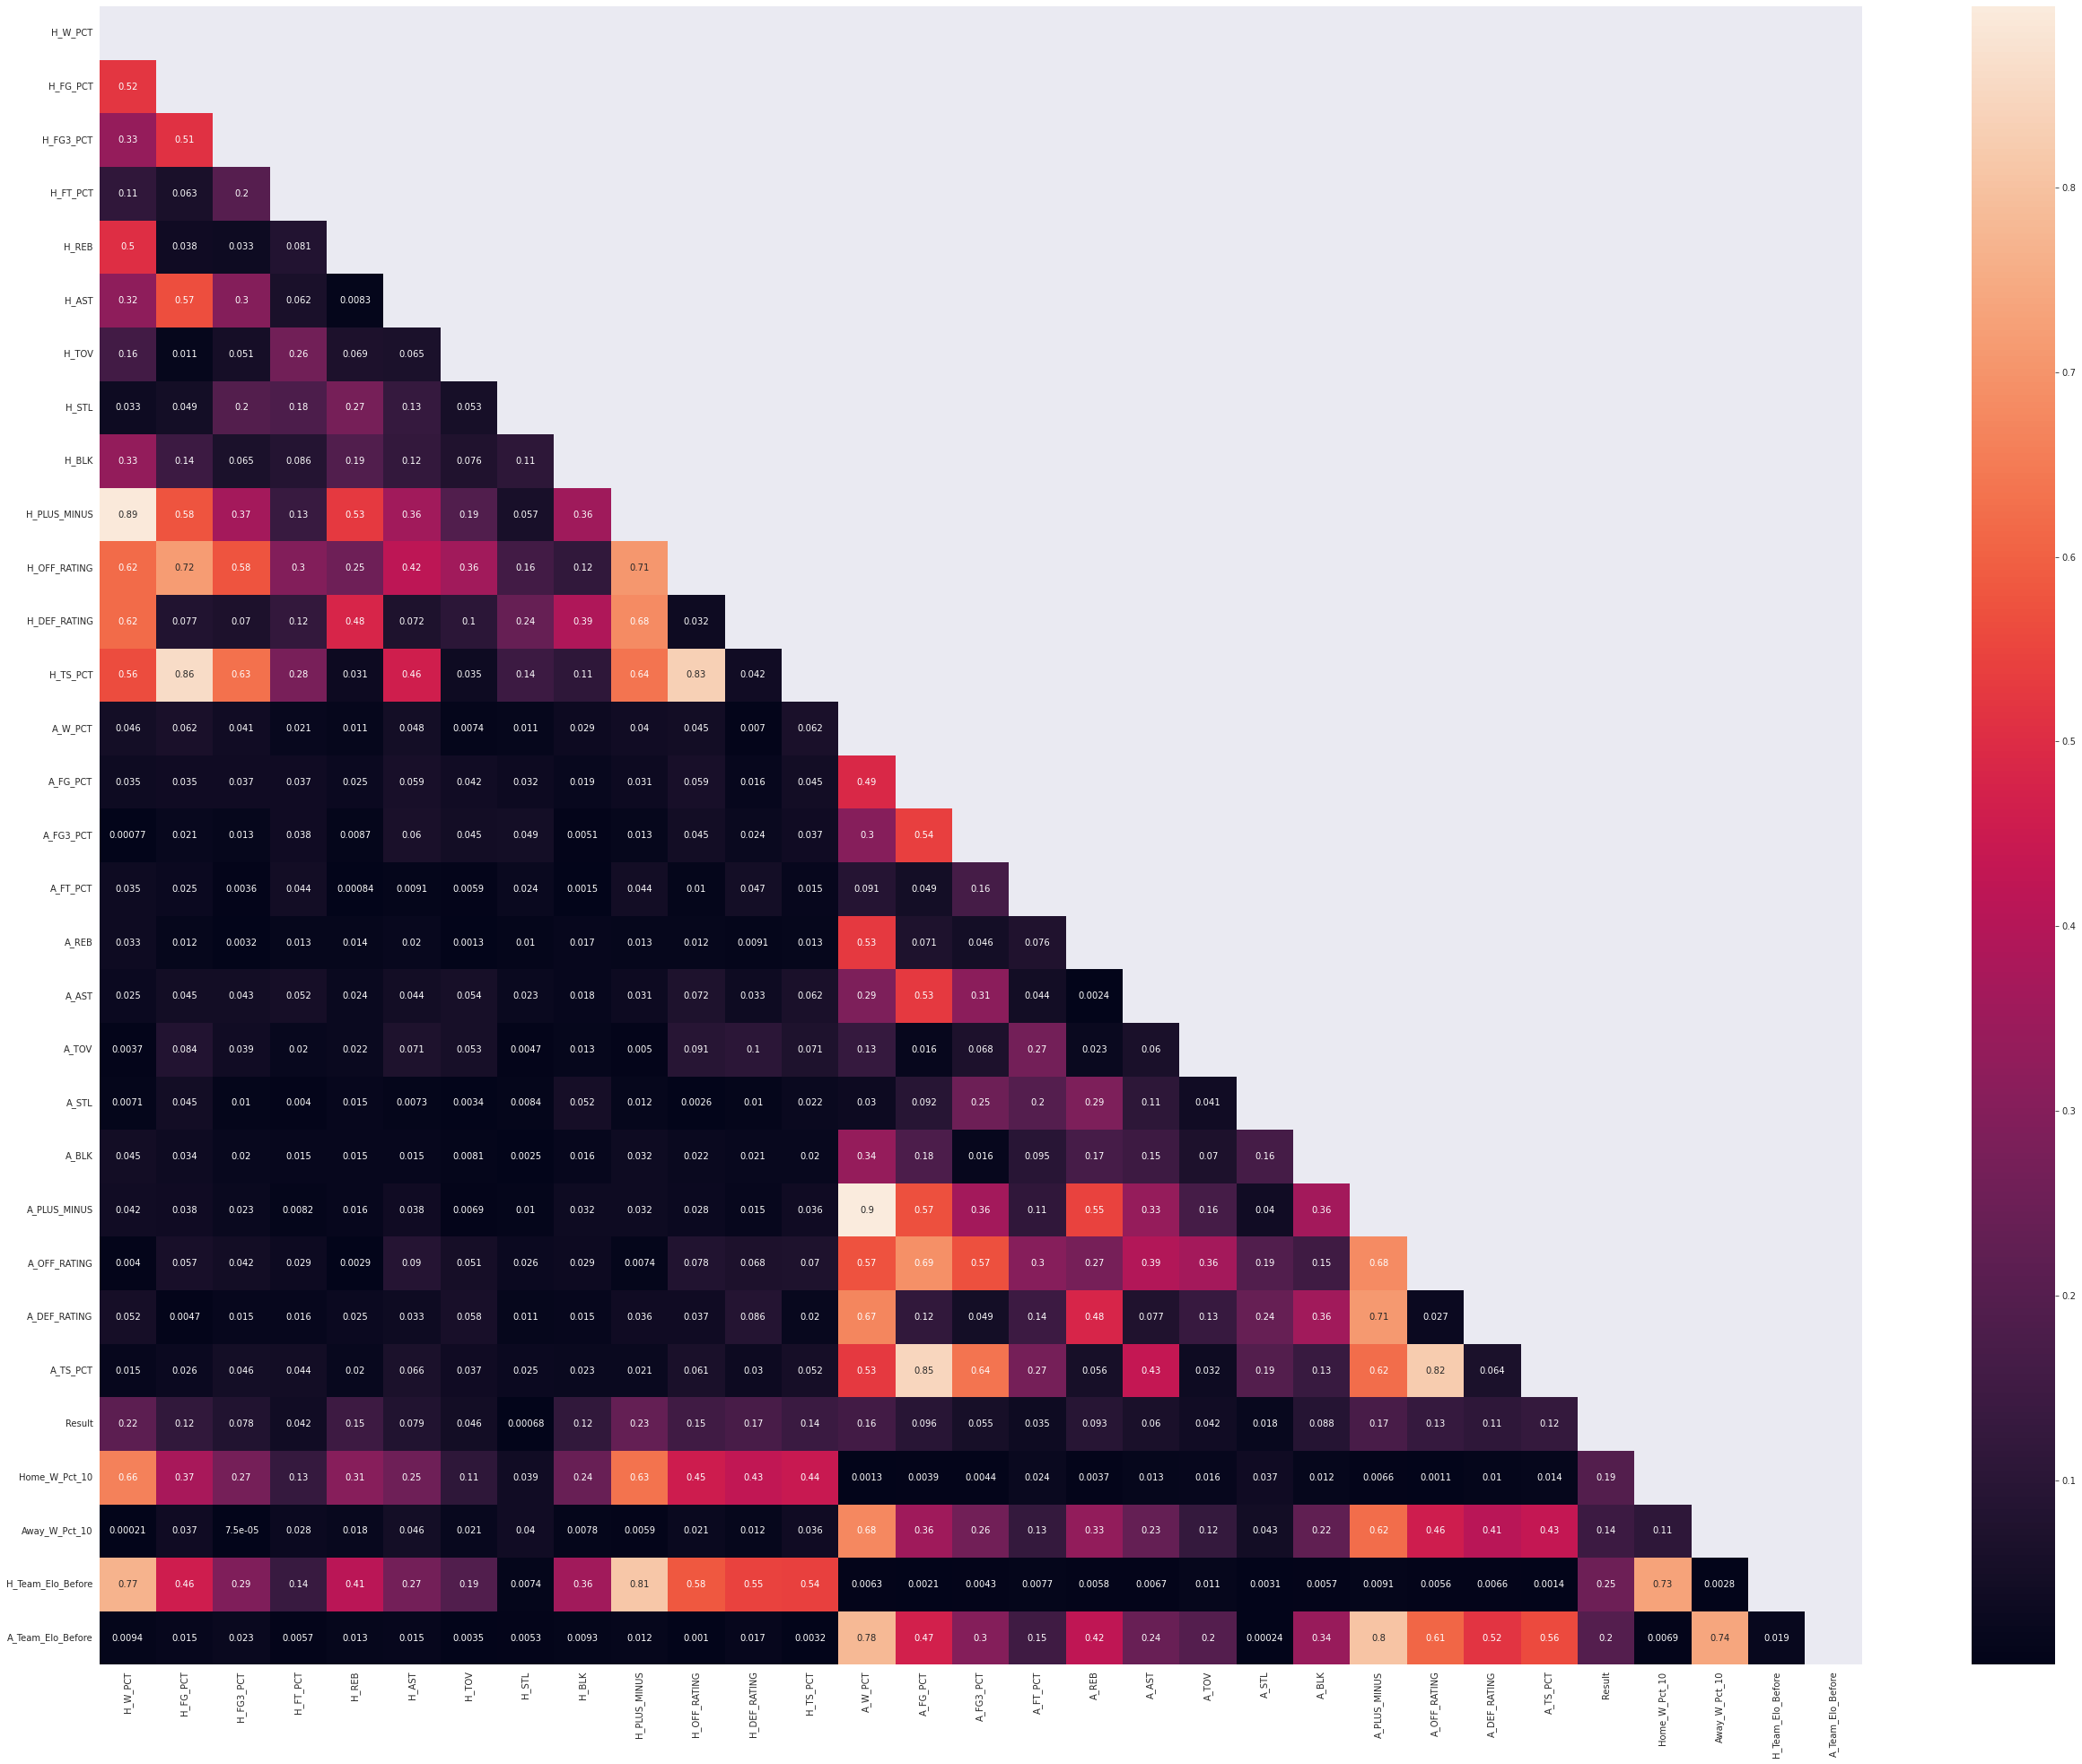

In [4]:
import numpy as np
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(44, 34))
    
    mask = np.triu(np.ones_like(final_df.corr(), dtype=bool))
    ax = sns.heatmap(abs(final_df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap');

In [5]:
final_df

,H_W_PCT,H_FG_PCT,H_FG3_PCT,H_FT_PCT,H_REB,H_AST,H_TOV,H_STL,H_BLK,H_PLUS_MINUS,...,A_BLK,A_PLUS_MINUS,A_OFF_RATING,A_DEF_RATING,A_TS_PCT,Result,Home_W_Pct_10,Away_W_Pct_10,H_Team_Elo_Before,A_Team_Elo_Before
0,0.000,0.488,0.185,0.682,38.6,27.7,18.8,8.9,5.0,-3.0,...,5.4,17.0,112.5,94.7,0.559,1,0.0,0.0,1500.000000,1500.000000
1,0.000,0.398,0.286,0.833,44.8,20.0,13.3,2.9,8.6,-8.6,...,5.8,-7.8,97.1,104.9,0.466,1,0.0,0.0,1500.000000,1500.000000
2,1.000,0.415,0.280,0.613,49.5,19.4,11.7,6.8,6.8,2.9,...,8.7,-1.0,107.7,109.7,0.551,0,0.0,0.0,1500.000000,1500.000000
3,1.000,0.519,0.481,0.737,41.1,19.6,15.9,7.5,3.7,5.6,...,6.8,7.8,104.9,97.1,0.525,0,0.0,0.0,1500.000000,1500.000000
4,1.000,0.494,0.412,0.750,55.3,25.2,20.4,4.9,3.9,1.0,...,7.3,29.2,115.6,87.4,0.626,1,0.0,0.0,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,0.325,0.430,0.353,0.790,46.9,22.7,13.5,6.8,4.2,-7.0,...,5.2,5.2,118.0,113.1,0.620,1,0.1,0.9,1361.862814,1602.339397
2816,0.375,0.452,0.340,0.724,43.5,23.3,15.9,8.2,5.3,-8.3,...,5.1,0.0,109.6,109.4,0.551,0,0.5,0.5,1352.067103,1511.547921
2817,0.500,0.469,0.371,0.756,44.3,22.8,14.1,8.1,5.2,0.8,...,4.6,-5.0,113.6,118.5,0.575,0,0.5,0.4,1525.805182,1412.532582
2818,0.537,0.459,0.347,0.792,43.3,26.1,15.4,7.5,4.0,-0.5,...,5.8,-0.3,110.7,111.1,0.574,0,0.8,0.2,1545.276747,1495.066690


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import final dataset
#final_df = pd.read_csv('')

#drop non numeric columns
#df.drop(columns = ['Home', 'Away', 'Game_ID', 'Date', 'Season'], axis = 1, inplace = True )

X = final_df.drop(columns = 'Result')

y = final_df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')

X train shape: (1889, 30)
X test shape: (931, 30)


In [7]:
print(f"""Raw Counts 
{final_df["Result"].value_counts()}\n
Percentages 
{final_df["Result"].value_counts(normalize=True)}


We would get an accuracy score of 0.566312 with a baseline model, i.e. about 56.6% accuracy

This is because about 56.6% of the results are wins""")

Raw Counts 
1    1597
0    1223
Name: Result, dtype: int64

Percentages 
1    0.566312
0    0.433688
Name: Result, dtype: float64


We would get an accuracy score of 0.566312 with a baseline model, i.e. about 56.6% accuracy

This is because about 56.6% of the results are wins


In [8]:
print(f"""Train percent wins
{y_train.value_counts(normalize=True)}\n""")

print(f"""Test percent wins: 
{y_test.value_counts(normalize=True)}\n""")

Train percent wins
1    0.566437
0    0.433563
Name: Result, dtype: float64

Test percent wins: 
1    0.566058
0    0.433942
Name: Result, dtype: float64



In [21]:
from sklearn.model_selection import cross_val_score


class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [28]:
# Create Dummy/Baseliner
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimator = DummyRegressor(strategy='mean')

# Create Dummy/Baseliner
from sklearn.dummy import DummyRegressor

pipe = Pipeline(steps=[
    ('estimator', DummyRegressor(strategy='mean'))
])

cv = ModelWithCV(pipe, 'estimator', X_train, y_train)

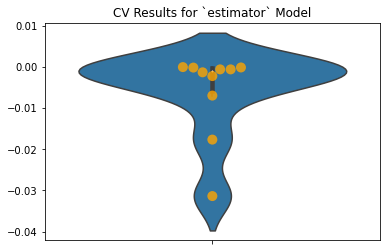

In [31]:
f, ax = plt.subplots()

cv.plot_cv(ax);

In [33]:
cv.print_cv_summary()

CV Results for `estimator` model:
            -0.00610 ± 0.00989 accuracy
        


In [34]:
# Import relevant class and function
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

pipe = Pipeline(steps=[
    #('scaler', StandardScaler()),
    #('pca', PCA(n_components=4)),
    ('estimator', LogisticRegression(random_state=42))
])

In [35]:
param_grid = {}
param_grid['estimator__C'] = np.logspace(-4, 4, 50)
param_grid['estimator__solver'] = ['liblinear']
param_grid['estimator__penalty'] = ['l1', 'l2']
param_grid['estimator__class_weight'] = ['balanced', None]
#params['logreg__n_jobs'] = [1]
param_grid['estimator__max_iter'] = [1000]

In [36]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid, cv=10, return_train_score=True, scoring='accuracy', verbose=1)

In [37]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logreg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02,...
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logreg__class_weight': ['balanced', None],
                         'logreg__max_iter': [1000],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

Mean Training Score: 64.31%

Mean Test Score: 63.37%

Accuracy Score: 63.37%

Optimal Parameters: {'logreg__C': 0.040949150623804234, 'logreg__class_weight': None, 'logreg__max_iter': 1000, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}

Testing Accuracy: 64.32%

              precision    recall  f1-score   support

           0       0.60      0.49      0.53       404
           1       0.65      0.75      0.70       527

    accuracy                           0.63       931
   macro avg       0.63      0.62      0.62       931
weighted avg       0.63      0.63      0.63       931



## XGB

In [59]:
from sklearn.pipeline import Pipeline
import xgboost as xgb

pipe = Pipeline(steps=[
    ('estimator', xgb.XGBRegressor(random_state=42))
])



In [78]:
param_grid = {}
param_grid['estimator__subsample'] = [0.5, 0.75, 1],
#param_grid['estimator__colsample_bytree'] = [0.5, 0.75, 1],
#param_grid['estimator__max_depth'] = [2, 6, 12],
#param_grid['estimator__min_child_weight'] = [1,5,15],,
#param_grid['estimator__learning_rate'] = [0.3, 0.1, 0.03]
#param_grid['estimator__n_estimators'] = [100]


In [79]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=10, 
                           return_train_score=True, 
                           scoring='accuracy',
                           verbose=1)


In [80]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    

C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\alvaro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

In [ ]:
rf_param_grid = {
    'n_estimators': [5, 7, 9, 13, 19],
    'criterion': ['log_loss', 'entropy'],
    'max_depth': [None, 3, 4, 5, 6, 14],
    'min_samples_split': [1, 2, 3, 4, 5],
    'min_samples_leaf': [40, 45, 50, 55, 60, 65, 70],
    'max_features' : ["sqrt", "log2", None],
    'class_weight' : [None, "balanced"],
    'max_samples': [None, 1, 5, 10, 15]
    
}

In [ ]:
rf_grid_search = GridSearchCV(estimator=rf_clf,
                             param_grid=rf_param_grid,
                             cv=3,
                             return_train_score=True)

rf_grid_search.fit(X_train, y_train)

# Mean training score
rf_gs_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])

# Mean test score
rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {np.round(rf_gs_training_score * 100, 2)}")
print(f"Mean Test Score: {np.round(rf_gs_testing_score * 100, 2)}")
print("Best Parameter Combination Found During Grid Search:")

print(f"Optimal Parameters: {rf_grid_search.best_params_}")


print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")

In [ ]:
rf_param_grid2 = {
    'n_estimators': [21, 23, 25],
    'criterion': ['log_loss', 'entropy', 'gini'],
    'max_depth': [None, 1, 2, 3, 4],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [60, 65, 70],
    'max_features' : ["sqrt", "log2", None],
    'class_weight' : [None, "balanced"],
    'max_samples': [None, 1, 5, 10]
    
}

In [ ]:
rf_grid_search = GridSearchCV(estimator=rf_clf,
                             param_grid=rf_param_grid2,
                             cv=10,
                             return_train_score=True)

rf_grid_search.fit(X_train, y_train)

# Mean training score
rf_gs_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])

# Mean test score
rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Mean Test Score: {rf_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")

print(f"Optimal Parameters: {rf_grid_search.best_params_}")


print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_rf_cv_score = cross_val_score(gnb,
                                  X_train,
                                  y_train,
                                  cv=10)

mean_gnb_cv_score = np.mean(gnb_rf_cv_score)



print(f"Mean Cross Validation Score for Gaussian Naive Bayes: {np.round(mean_gnb_cv_score * 100, 2)}%")

In [ ]:
gnb_param_grid = {
    'var_smoothing': np.logspace(0,-5, num=100),
    #'var_smoothing': [1e-11, 1e-10, 1e-9]
}

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
gnb_grid_search = GridSearchCV(estimator=gnb,
                             param_grid=gnb_param_grid,
                             cv=10,
                             return_train_score=True)

gnb_grid_search.fit(X_train, y_train)

# Mean training score
gnb_grid_train_score = np.mean(gnb_grid_search.cv_results_['mean_train_score'])

# Mean test score
gnb_grid_test_score = gnb_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {gnb_grid_train_score: .2%}\n")
print(f"Mean Test Score: {gnb_grid_test_score: .2%}\n")

print("Best Parameter Combination Found During Grid Search:")
print(f"Optimal Parameters: {gnb_grid_search.best_params_}\n")
print(f"Testing Accuracy: {gnb_grid_search.best_score_: .2%}\n")


best_gnb_grid = gnb_grid_search.best_estimator_
best_gnb_grid.fit(X_train, y_train)
y_pred_gnb = best_gnb_grid.predict(X_test)

print(classification_report(y_test, y_pred_gnb))

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, baseline_model.predict(X_test))

In [ ]:
from sklearn.metrics import log_loss
import numpy as np

log_loss(y_train, np.zeros(len(y_train)))

In [ ]:
# Run this cell without changes
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Negative log loss doesn't exist as something we can import,
# but we can create it
neg_log_loss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Instantiate the model (same as previous example)
baseline_model = LogisticRegression(random_state=42)

# Create a list to hold the score from each fold
kfold_scores = np.ndarray(5)

# Instantiate a splitter object and loop over its result
kfold = StratifiedKFold()
for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    # Extract train and validation subsets using the provided indices
    X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Clone the provided model and fit it on the train subset
    temp_model = clone(baseline_model)
    temp_model.fit(X_t, y_t)
    
    # Evaluate the provided model on the validation subset
    neg_log_loss_score = neg_log_loss(temp_model, X_val, y_val)
    kfold_scores[fold] = neg_log_loss_score
    
-(kfold_scores.mean())

In [ ]:
print(baseline_neg_log_loss_cv)
print(kfold_scores)

In [ ]:
model_less_regularization = LogisticRegression(solver="saga",
                                              penalty="elasticnet",
                                              l1_ratio=.5,
                                              random_state=42,
                                              class_weight={1: 0.33},
                                              C=1e5)

In [ ]:
# Ignore this cell
model_less_regularization.get_params()

In [ ]:
print("solver:", model_less_regularization.get_params()["solver"])
print("penalty:", model_less_regularization.get_params()["penalty"])

In [ ]:
# Ignore this cell
model_alternative_solver = LogisticRegression(solver="lbfgs",
                                              penalty="l2",
                                              l1_ratio=.5,
                                              random_state=42,
                                              class_weight={1: 0.33},
                                              C=1e5)
model_alternative_solver

In [ ]:
model_more_iterations = LogisticRegression(solver="saga",
                                              penalty="elasticnet",
                                              l1_ratio=.5,
                                              random_state=42,
                                              class_weight={1: 0.33},
                                              C=1e5,
                                              max_iter=2000)


In [ ]:
final_model = model_less_regularization

In [ ]:
# Instantiate StandardScaler
scaler = StandardScaler()


# Fit and transform X_train
X_train_scaled = scaler.fit_transform(X_train)


# Transform X_test
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Instantiate SMOTE with random_state=42 and sampling_strategy=0.28
# sm = SMOTE(random_state=42, sampling_strategy=.40)
from imblearn.over_sampling import SMOTE

# Fit and transform X_train_scaled and y_train using sm
#X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train_scaled, y_train)

In [ ]:
final_model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, final_model.predict(X_test_scaled))

In [ ]:
# Import the relevant function
from sklearn.metrics import precision_score

# Display the precision score
precision_score(y_test, final_model.predict(X_test_scaled))

In [ ]:
# Import the relevant function
from sklearn.metrics import recall_score

# Display the recall score
recall_score(y_test, final_model.predict(X_test_scaled))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

#script to test the effectivenes of each model, uses default parameters
#test six different classification models 
def run_exps(X_train, y_train, X_test, y_test) :
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    
    results = []
    
    names = []
    
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    
    target_names = ['win', 'loss']
    
    for name, model in models:
        
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    final = pd.concat(dfs, ignore_index=True)
    
    return final
final = run_exps(X_train, y_train, X_test, y_test)
final

# Model Performance

In [ ]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [ ]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

# Final Selected Model
- grid search for parameters 
- Gaussian NB

In [ ]:
# Gaussian NB only has one parameter 'var_smoothing'
# Portion of the largest variance of all features that is added to variances for calculation stability.
# Number of different combinations of parameters 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

nb_classifier = GaussianNB()

target_names = ['Win', 'Loss']

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)

gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=kfold,   
                 verbose=1, 
                 scoring='accuracy', n_jobs=-1) 

gs_NB.fit(X_train, y_train)

best_gs_grid = gs_NB.best_estimator_
best_gs_grid.fit(X_train, y_train)
y_pred_best_gs = best_gs_grid.predict(X_test)

print(classification_report(y_test, y_pred_best_gs, target_names=target_names))
gs_NB.best_params_

In [ ]:
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(y_test, y_pred_best_gs)
print(confusionMatrix)

# Confusion Matrix

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred_best_gs)  

    # Code below prints model accuracy information
print('Coefficient Information:')

for i in range(len(featureColumns)):  

    logregCoefficients = logreg.coef_

    currentFeature = featureColumns[i]
    currentCoefficient = logregCoefficients[0][i]

    print(currentFeature + ': ' + str(currentCoefficient))

print('----------------------------------')

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred))
print("Precision:", metrics.precision_score(Y_test, Y_pred))
print("Recall:", metrics.recall_score(Y_test, Y_pred))

print('----------------------------------')

print('Confusion Matrix:')
print(confusionMatrix)

# Saving Model

In [ ]:
import pickle

# Saves the model in folder to be used in future
# filename should be end in '.pkl'
def save_model(model, filename):

    with open(filename, 'wb') as file:
        pickle.dump(model, file)
save_model()